# SwinTransformer backbone for IR-drop 


## 1. Model Architecture

### 1.1 SwinTransformer Backbone
* **Configuration**:
  - Initial convolution layer: 4 → 3 channels 
  - Pretrained `swin_base_patch4_window7_224` as backbone for feature extraction
  - Patch size: 4x4
  - Window size: 7x7

### 1.2 Decoder Structure
* **Architecture**: UNet-style decoder with 5 sequential blocks
* **Decoder Block Components**:
  ```
  For each block:
  - Conv2d(in_channels, out_channels, kernel=3, padding=1)
  - ReLU
  - Conv2d(out_channels, out_channels, kernel=3, padding=1)
  - ReLU
  - ConvTranspose2d(out_channels, out_channels, kernel=2, stride=2)
  ```
* **Channel Progression**:
  ```
  1024 → 512 → 256 → 128 → 64 → 32 → 1
  ```
* **Final Layers**:
  - 1x1 convolution
  - Sigmoid activation

## 2. Data Preprocessing

### 2.1 Input Features
* **Power Features**:
  ```python
  feature_dirs = [
      'power_i',
      'power_s',
      'power_sca',
      'Power_all'
  ]
  ```

### 2.2 Processing Pipeline
```python
# Original size: [259, 259]
# Target size:  [224, 224]

1. Load numpy array → [259, 259]
2. Interpolate: F.interpolate(
       input,
       size=(224, 224),
       mode='bilinear',
       align_corners=True
   )
3. Normalize: (x - min) / (max - min)
4. Stack features: torch.stack(features, dim=0)
   Result: [4, 224, 224]
5. Batch processing(batch size = 16): [16, 4, 224, 224]
```

### 2.3 Label Processing
```python
1. Load IR drop values
2. Interpolate to [224, 224]
3. label = label.clamp(1e-6, 50)
4. label = (torch.log10(label) + 6) / (np.log10(50) + 6)
```

## 3. Input/Output size

### Input Size
```python
[B, C, H, W] = [16, 4, 224, 224]
where:
- B: Batch size (16)
- C: Channel count (4 power features)
- H, W: Height, Width (224x224)
```

### Output Size
```python
[B, C, H, W] = [16, 1, 224, 224]
where:
- B: Batch size (16)
- C: Channel count (1 IR drop prediction)
- H, W: Height, Width (224x224)
```

## 4. Learning Strategy

### 4.1 Hyperparameters
```python
config = {
    'batch_size': 16,
    'learning_rate': 2e-3,
    'weight_decay': 1e-4,
    'accuracy_threshold': 0.1
}
```

### 4.2 Optimizer
```python
optimizer = AdamW([
    {'params': backbone_params, 'lr': learning_rate * 0.1},
    {'params': decoder_params, 'lr': learning_rate}
], weight_decay=1e-4)
```

### 4.3 Learning Rate Schedule
```python
scheduler = OneCycleLR(
    optimizer,
    max_lr=[learning_rate * 0.1, learning_rate],
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=1e4
)
```

## 5. Evaluation Metrics

### 5.1 Accuracy Calculation

* Accuracy: within +/- 10% error bar--> accurate

### 5.2 Loss Function
* Primary: L1 Loss
* Monitoring metrics:
  - Training/Validation loss
  - Training/Validation accuracy
  - Learning rates (backbone and decoder)

## 6. Sample Input/Output





Average Metrics across all samples:
Accuracy (within 10% error): 64.58%
RMSE: 0.4082
MAE: 0.2425
Mean Relative Error: 35.42%


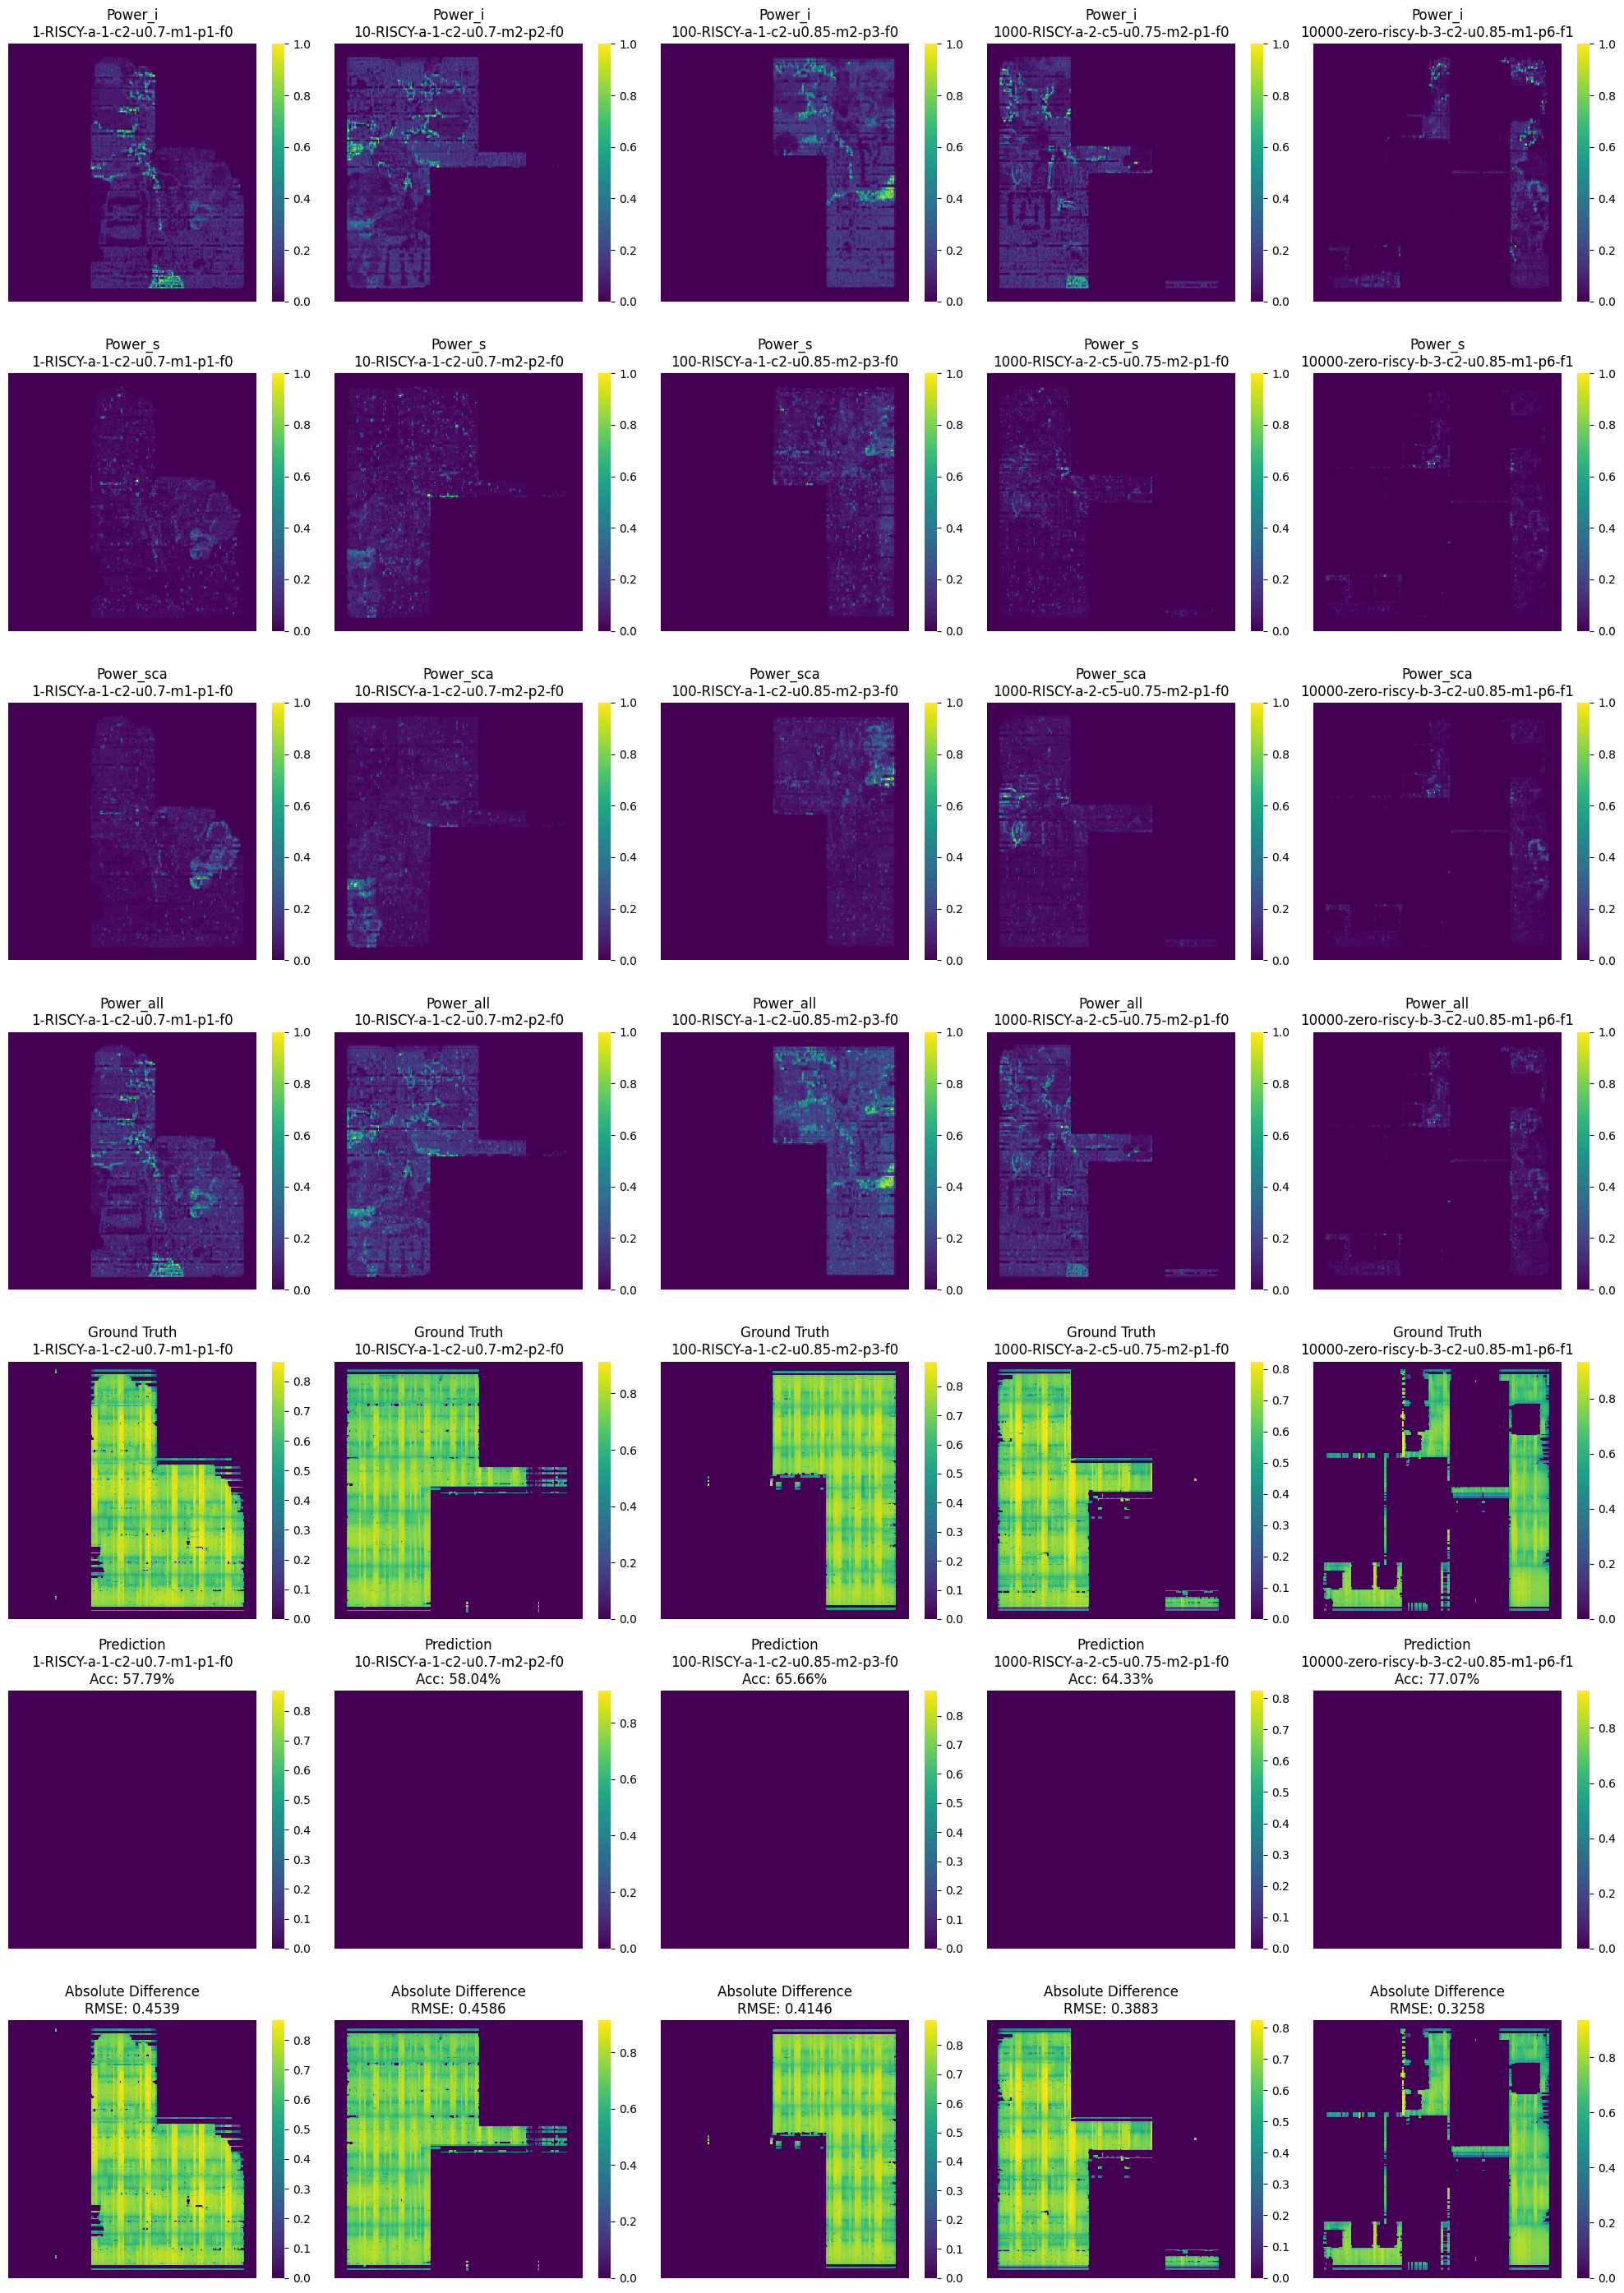

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from swintransformer_v1 import init_model
import torch.nn.functional as F

def calculate_metrics(pred, target):
    # Calculate relative error
    relative_error = torch.abs(pred - target) / (target + 1e-8)
    
    # Calculate accuracy (within 10% error)
    accuracy = (relative_error <= 0.1).float().mean() * 100.0
    
    # Calculate RMSE
    rmse = torch.sqrt(torch.mean((pred - target) ** 2))
    
    # Calculate Mean Absolute Error
    mae = torch.mean(torch.abs(pred - target))
    
    return {
        'accuracy': accuracy.item(),
        'rmse': rmse.item(),
        'mae': mae.item(),
        'mean_relative_error': relative_error.mean().item() * 100
    }

def load_and_preprocess_data(root_dir, filename, target_size=(224, 224)):
    feature_dirs = ['power_i', 'power_s', 'power_sca', 'Power_all']
    features = []
    
    # Load and process features
    for dir_name in feature_dirs:
        file_path = os.path.join(root_dir, dir_name, filename)
        feature = np.load(file_path)
        feature = torch.tensor(feature, dtype=torch.float32)
        feature = F.interpolate(feature.unsqueeze(0).unsqueeze(0),
                              size=target_size,
                              mode='bilinear',
                              align_corners=True).squeeze()
        # Normalize feature
        min_val = feature.min()
        max_val = feature.max()
        if max_val != min_val:
            feature = (feature - min_val) / (max_val - min_val)
        else:
            feature = torch.zeros_like(feature)
        features.append(feature)
    
    # Load ground truth IR drop
    ir_path = os.path.join(root_dir, 'IR_drop', filename)
    ir_drop = np.load(ir_path)
    ir_drop = torch.tensor(ir_drop, dtype=torch.float32)
    ir_drop = F.interpolate(ir_drop.unsqueeze(0).unsqueeze(0),
                           size=target_size,
                           mode='bilinear',
                           align_corners=True).squeeze()
    
    # Process IR drop
    ir_drop = ir_drop.clamp(1e-6, 50)
    ir_drop = (torch.log10(ir_drop) + 6) / (np.log10(50) + 6)
    
    return torch.stack(features), ir_drop

def visualize_results(model, device, root_dir, filenames):
    model.eval()
    
    # Create figure
    num_samples = len(filenames)
    fig, axes = plt.subplots(7, num_samples, figsize=(num_samples*4, 28))
    
    # Keep track of overall metrics
    all_metrics = []
    
    with torch.no_grad():
        for idx, filename in enumerate(filenames):
            # Load and process data
            features, ir_drop = load_and_preprocess_data(root_dir, filename)
            
            # Get model prediction
            input_tensor = features.unsqueeze(0).to(device)  # Add batch dimension
            prediction = model(input_tensor).cpu().squeeze()
            
            # Calculate metrics for this sample
            metrics = calculate_metrics(prediction, ir_drop)
            all_metrics.append(metrics)
            
            # Get global min and max for consistent visualization
            vmin = min(ir_drop.min().item(), prediction.min().item())
            vmax = max(ir_drop.max().item(), prediction.max().item())
            
            # Plot input features
            feature_names = ['Power_i', 'Power_s', 'Power_sca', 'Power_all']
            for i, (feature, name) in enumerate(zip(features, feature_names)):
                sns.heatmap(feature.numpy(), ax=axes[i, idx], cmap='viridis')
                axes[i, idx].set_title(f"{name}\n{filename}")
                axes[i, idx].axis('off')
            
            # Plot ground truth
            sns.heatmap(ir_drop.numpy(), ax=axes[4, idx], cmap='viridis', vmin=vmin, vmax=vmax)
            axes[4, idx].set_title(f"Ground Truth\n{filename}")
            axes[4, idx].axis('off')
            
            # Plot prediction
            sns.heatmap(prediction.numpy(), ax=axes[5, idx], cmap='viridis', vmin=vmin, vmax=vmax)
            axes[5, idx].set_title(f"Prediction\n{filename}\nAcc: {metrics['accuracy']:.2f}%")
            axes[5, idx].axis('off')
            
            # Plot difference
            diff = torch.abs(prediction - ir_drop)
            sns.heatmap(diff.numpy(), ax=axes[6, idx], cmap='viridis')
            axes[6, idx].set_title(f"Absolute Difference\nRMSE: {metrics['rmse']:.4f}")
            axes[6, idx].axis('off')
    
    plt.tight_layout()
    
    # Calculate and print average metrics
    avg_metrics = {
        key: np.mean([m[key] for m in all_metrics]) 
        for key in all_metrics[0].keys()
    }
    
    print("\nAverage Metrics across all samples:")
    print(f"Accuracy (within 10% error): {avg_metrics['accuracy']:.2f}%")
    print(f"RMSE: {avg_metrics['rmse']:.4f}")
    print(f"MAE: {avg_metrics['mae']:.4f}")
    print(f"Mean Relative Error: {avg_metrics['mean_relative_error']:.2f}%")
    
    plt.show()
    
    # Return metrics for further analysis if needed
    return all_metrics, avg_metrics

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = init_model('swin_base_patch4_window7_224', input_channels=4, num_classes=0, pretrained=False)

# Load trained weights
checkpoint = torch.load('./checkpoints/best_model1_78.44_66.94.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# Set paths and filenames
root_dir = './CircuitNet-N28/IR_drop_features_decompressed'
filenames = sorted(os.listdir(os.path.join(root_dir, 'power_i')))[:5]  # Get first 5 files

# Visualize results and get metrics
all_metrics, avg_metrics = visualize_results(model, device, root_dir, filenames)

# MAVIRED Model Analysis Report

## 1. Model Architecture

```python
# 3D Encoder Path
inc: DoubleConv3d(1 -> 64)
down1: Down(64 -> 128)
down2: Down(128 -> 256)
down3: Down(256 -> 512)
# 2D Decoder Path
up1: Up(512 -> 256/2)  # bilinear=True factor=2
up2: Up(256 -> 128/2)
up3: Up(128 -> 64)
outc: OutConv(64 -> 1)
```

### 1.1 DoubleConv3D Block
```python
Sequential(
    Conv3d(in_channels, mid_channels, kernel=3, padding=(0,1,1))
    BatchNorm3d(mid_channels)
    ReLU
    Conv3d(mid_channels, out_channels, kernel=3, padding=(0,1,1))
    BatchNorm3d(out_channels)
    ReLU
)
```

### 1.2 Down Block
```python
Sequential(
    MaxPool3d((1,2,2), stride=(1,2,2))
    DoubleConv3d
)
```

### 1.3 Up Block
```python
if bilinear:
    Upsample(scale_factor=2, mode='bilinear')
    DoubleConv2d(in_channels, out_channels, in_channels//2)
else:
    ConvTranspose2d(in_channels, in_channels//2, kernel=2, stride=2)
    DoubleConv2d(in_channels, out_channels)
```

## 2. Data Preprocessing

### 2.1 Data Organization
* Single input channel for power values
* 24 temporal timesteps
* Spatial dimensions: 256x256
* Train/test split via annotations file

### 2.2 Processing Pipeline
```python
1. Load .npy files
2. Transpose: [H,W,C] -> [C,H,W]
3. Add temporal dimension
4. Convert to float32
5. Batch processing: [B,1,24,256,256]
```

## 3. Input Size
```python
[B, C, T, H, W] = [2, 1, 24, 256, 256]
where:
- B: Batch size (2)
- C: Channel count (1 power feature)
- T: Temporal field (24 timesteps)
- H, W: Height, Width (256x256)
```

## 4. Output Size
```python
[B, H, W] = [2, 256, 256]
where:
- B: Batch size (2)
- H, W: Height, Width (256x256)
```

## 5. Learning Strategy

### 5.1 Training Configuration
```python
arg_dict = {
    'batch_size': 2,
    'lr': 0.0002,
    'weight_decay': 0.01,
    'max_iters': 200,
    'loss_type': 'L1Loss'
}
```

### 5.2 Optimizer
```python
optimizer = AdamW(
    model.parameters(),
    lr=arg_dict['lr'],
    betas=(0.9, 0.999),
    weight_decay=arg_dict['weight_decay']
)
```

### 5.3 Learning Rate Schedule
```python
CosineRestartLr(
    base_lr=arg_dict['lr'],
    periods=[max_iters],
    restart_weights=[1],
    min_lr=1e-7
)
```

### 5.4 Training Features
* Checkpoint saving: every 100 iterations
* Learning rate: Cosine annealing
* Mode switching: training/test
* Optimizer: AdamW with weight decay

## 6. Evaluation Metrics

### 6.1 Primary Metrics
* Training: L1 Loss
* Evaluation: 
  - NRMS (Normalized Root Mean Square)
  - SSIM (Structural Similarity Index)

### 6.2 Threshold Settings
```python
threshold = 0.9885  # For binary classifier
```

### 6.3 Testing Protocol
1. Model forward pass
2. Loss computation
3. Metric calculation (NRMS, SSIM)
4. Optional ROC curve generation



<Figure size 1500x1500 with 0 Axes>

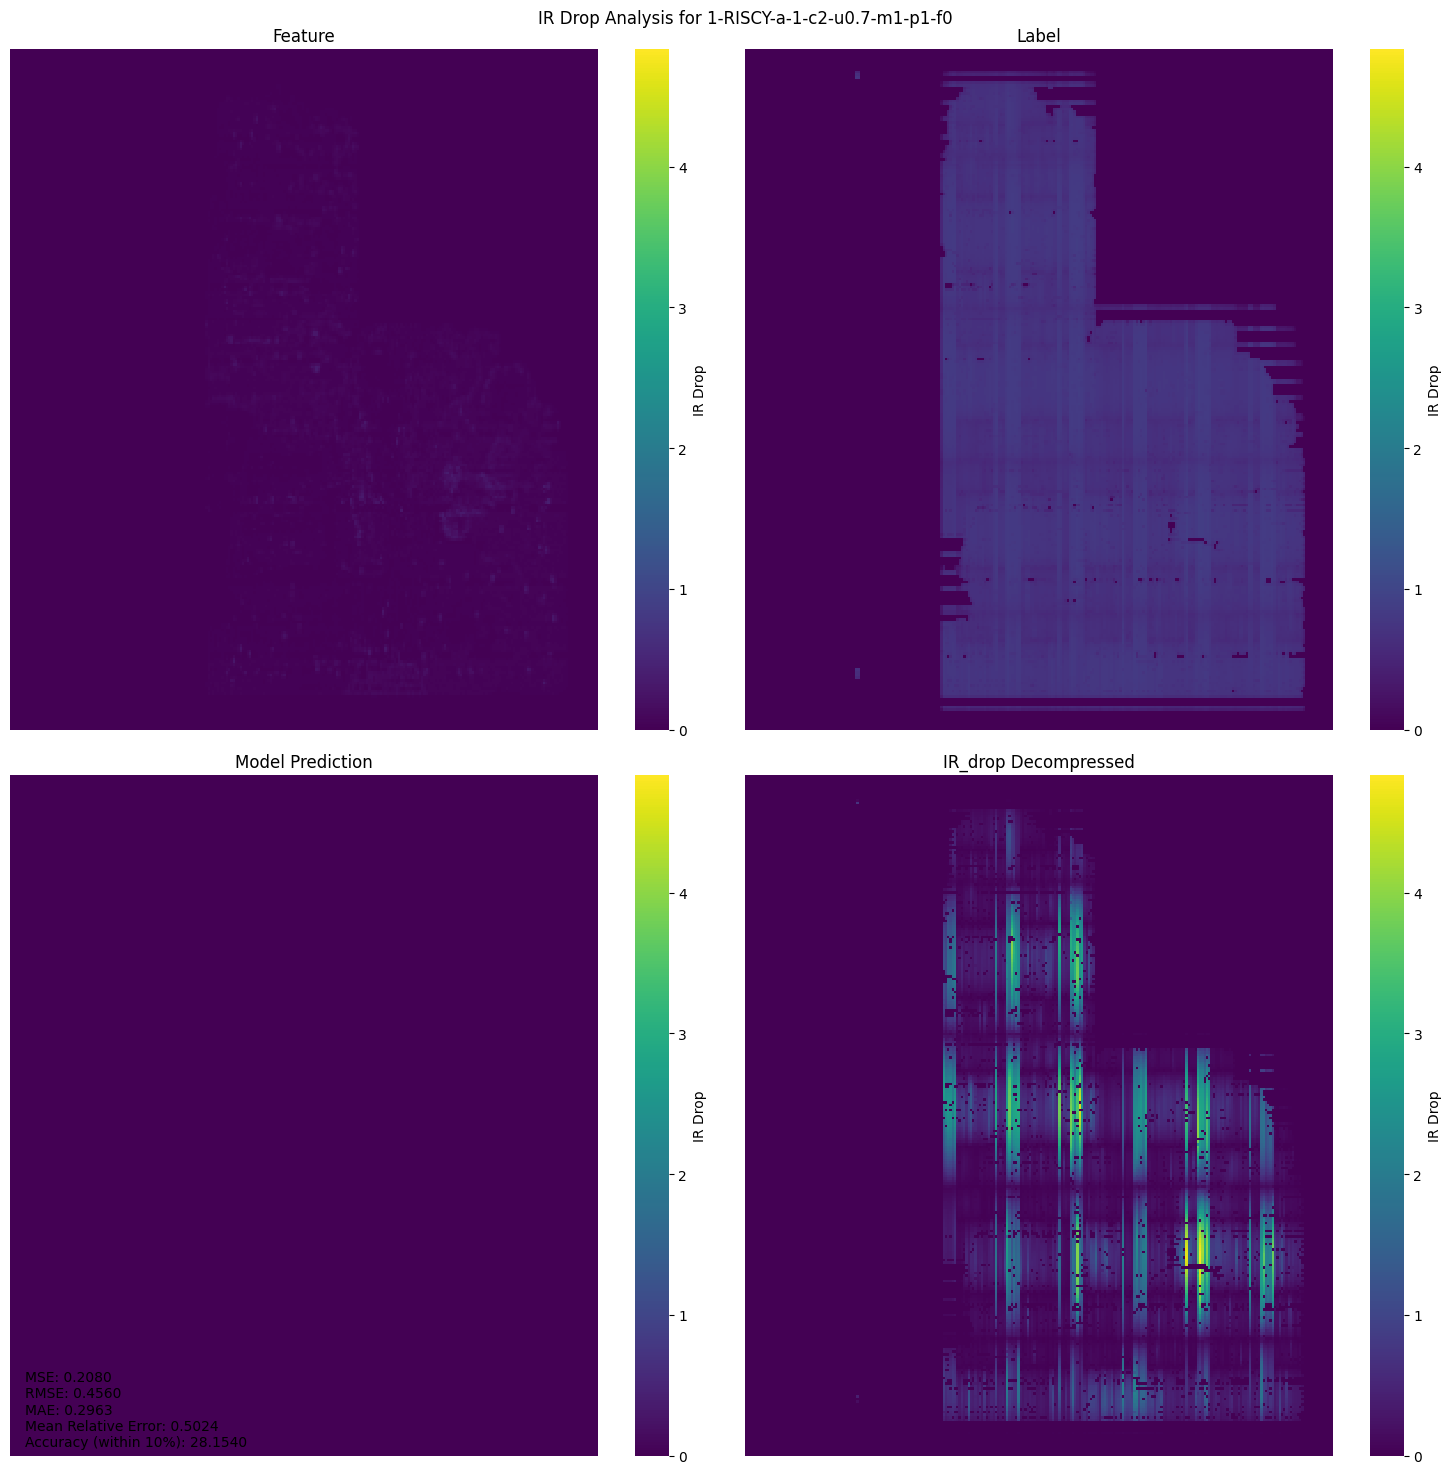

<Figure size 1500x1500 with 0 Axes>

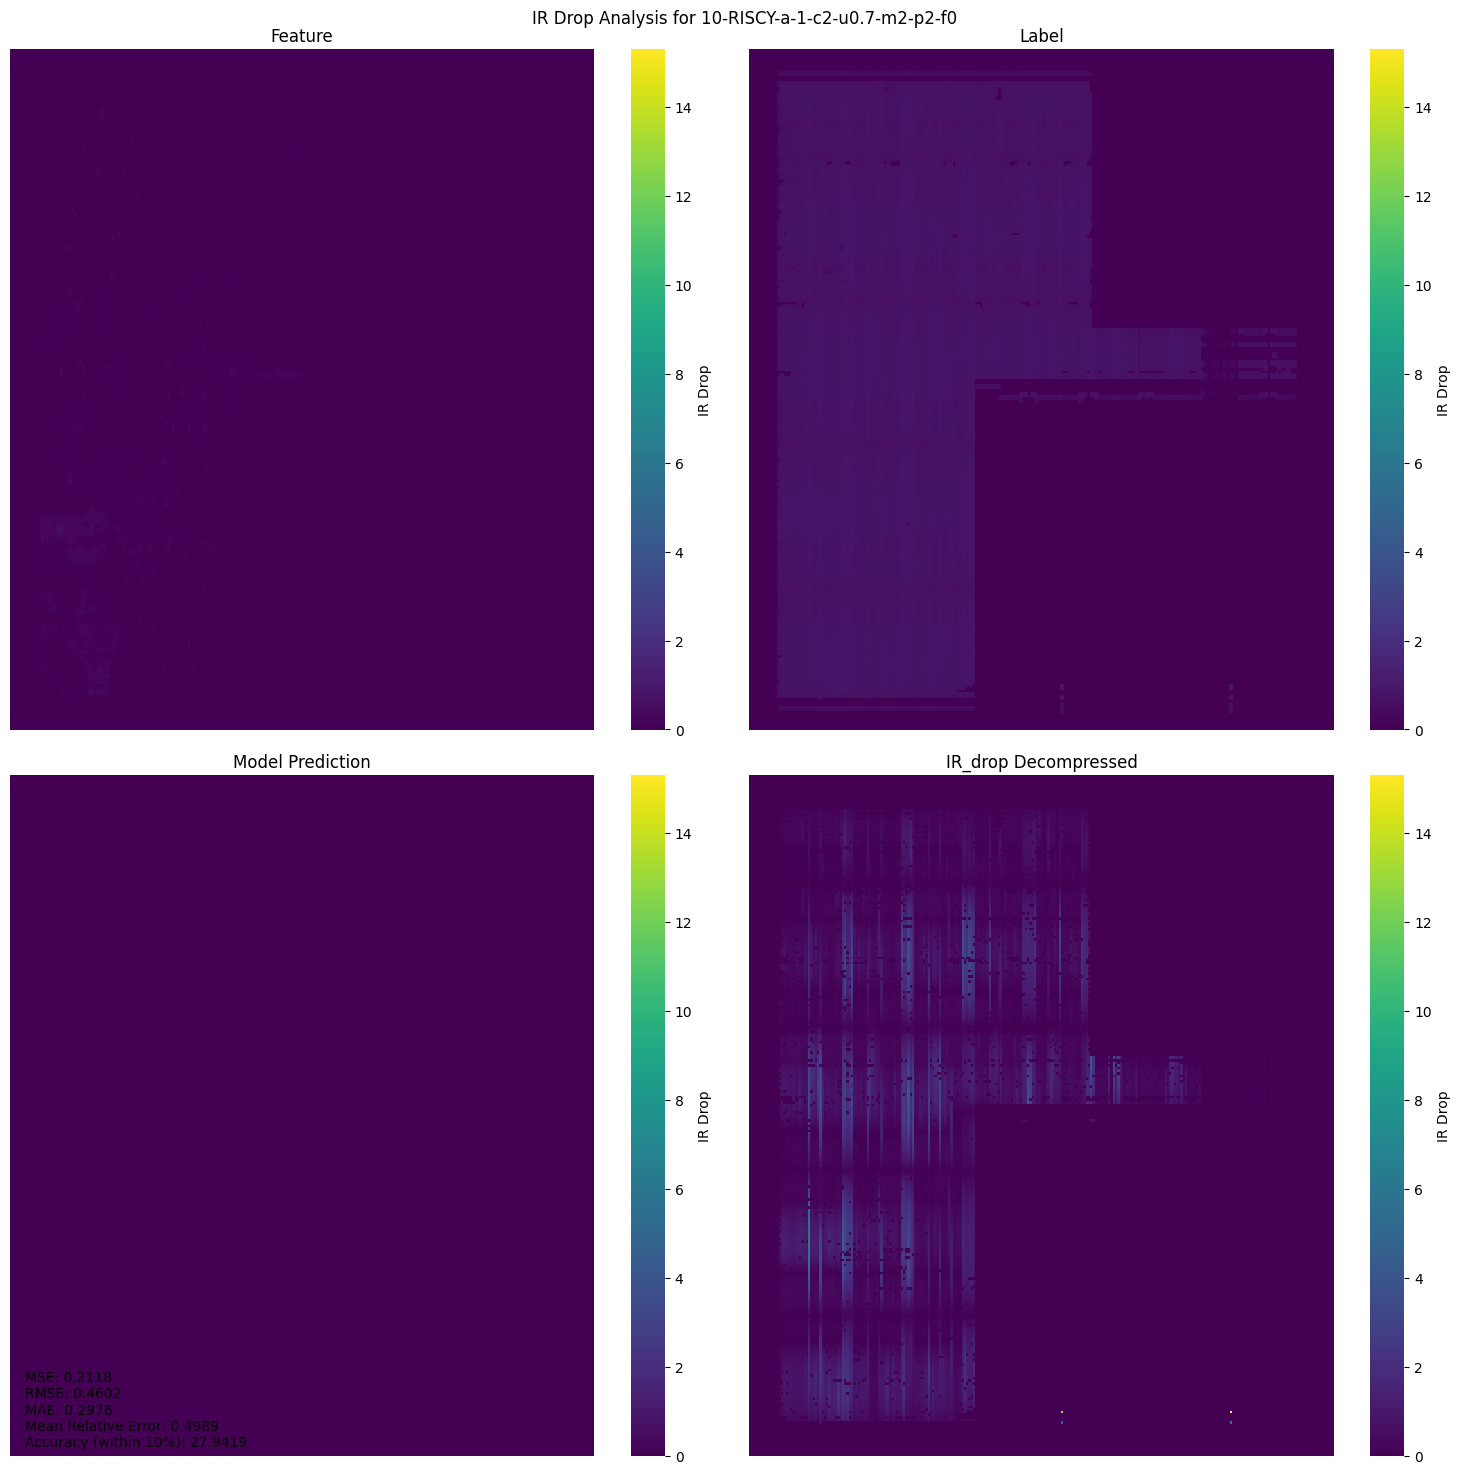

<Figure size 1500x1500 with 0 Axes>

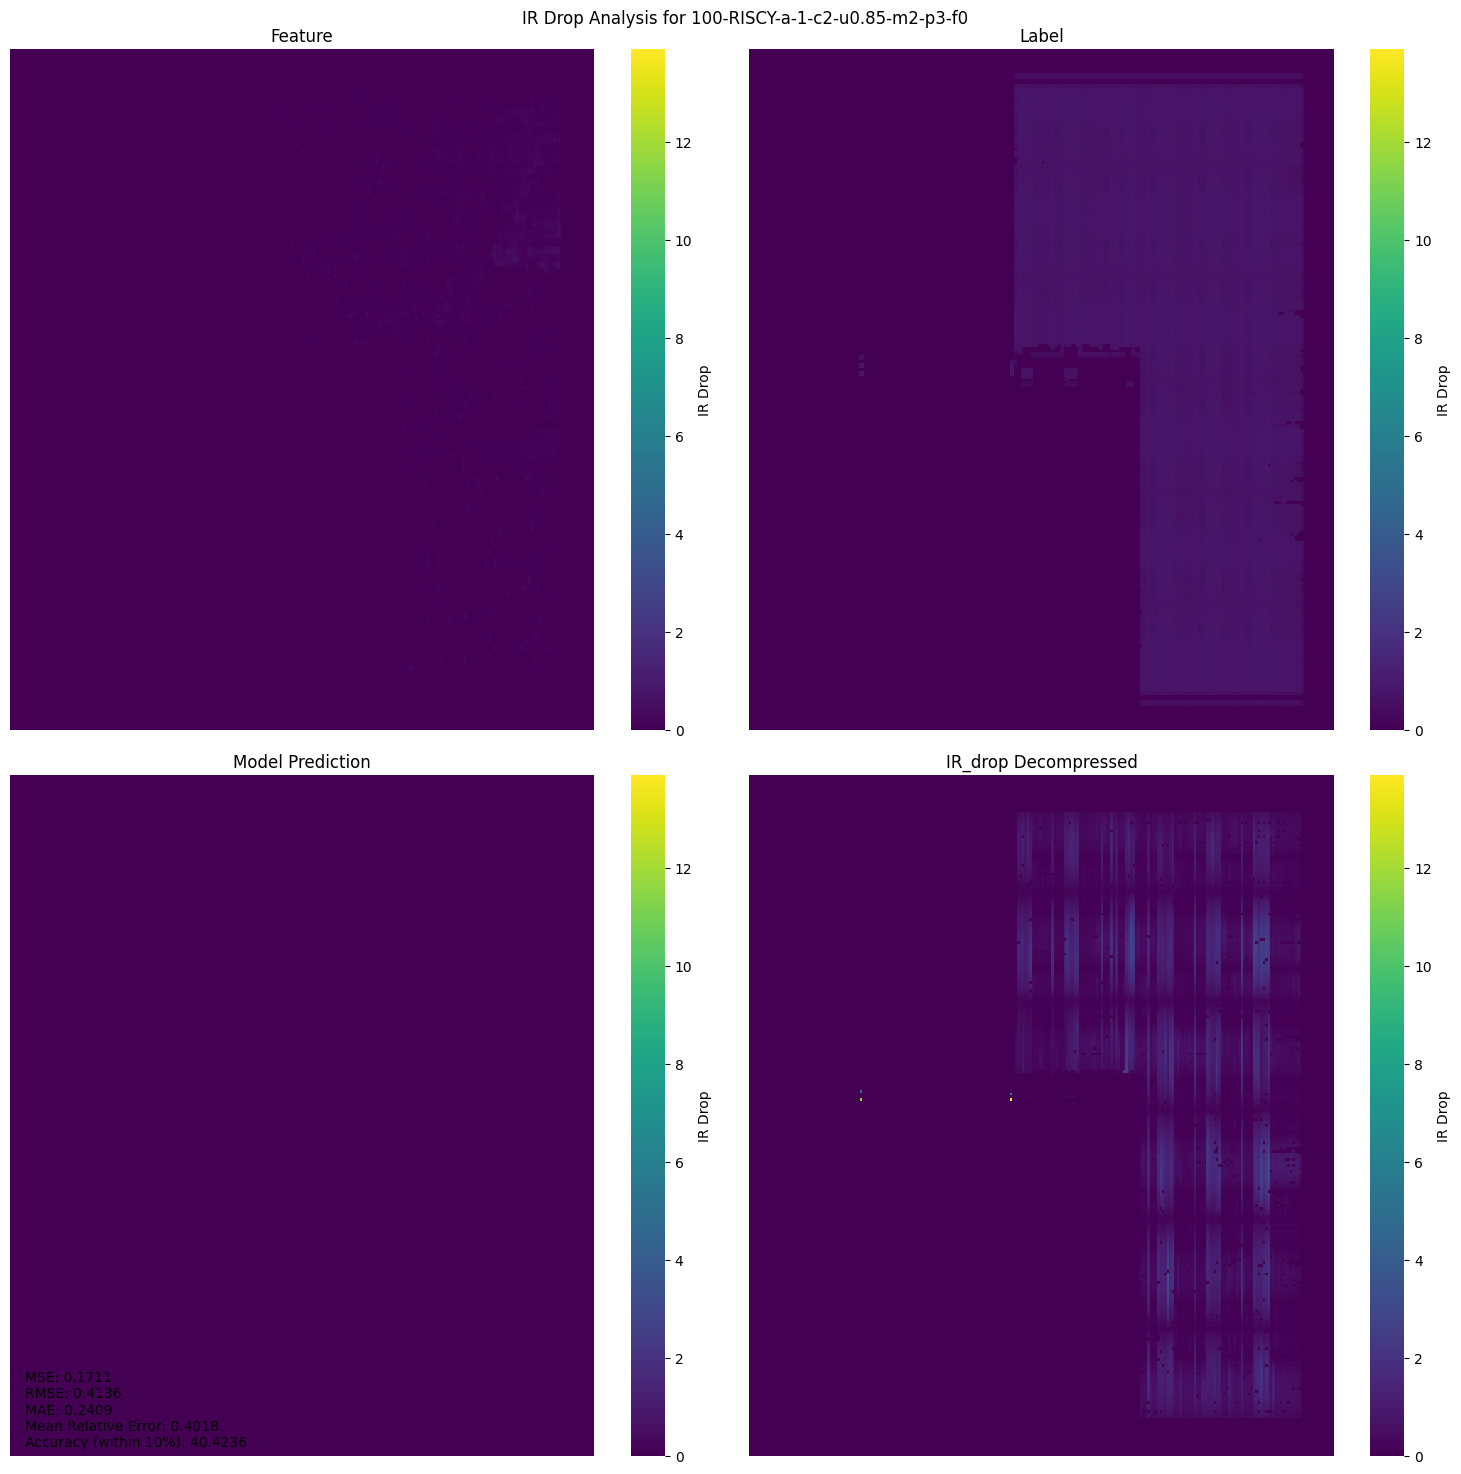

<Figure size 1500x1500 with 0 Axes>

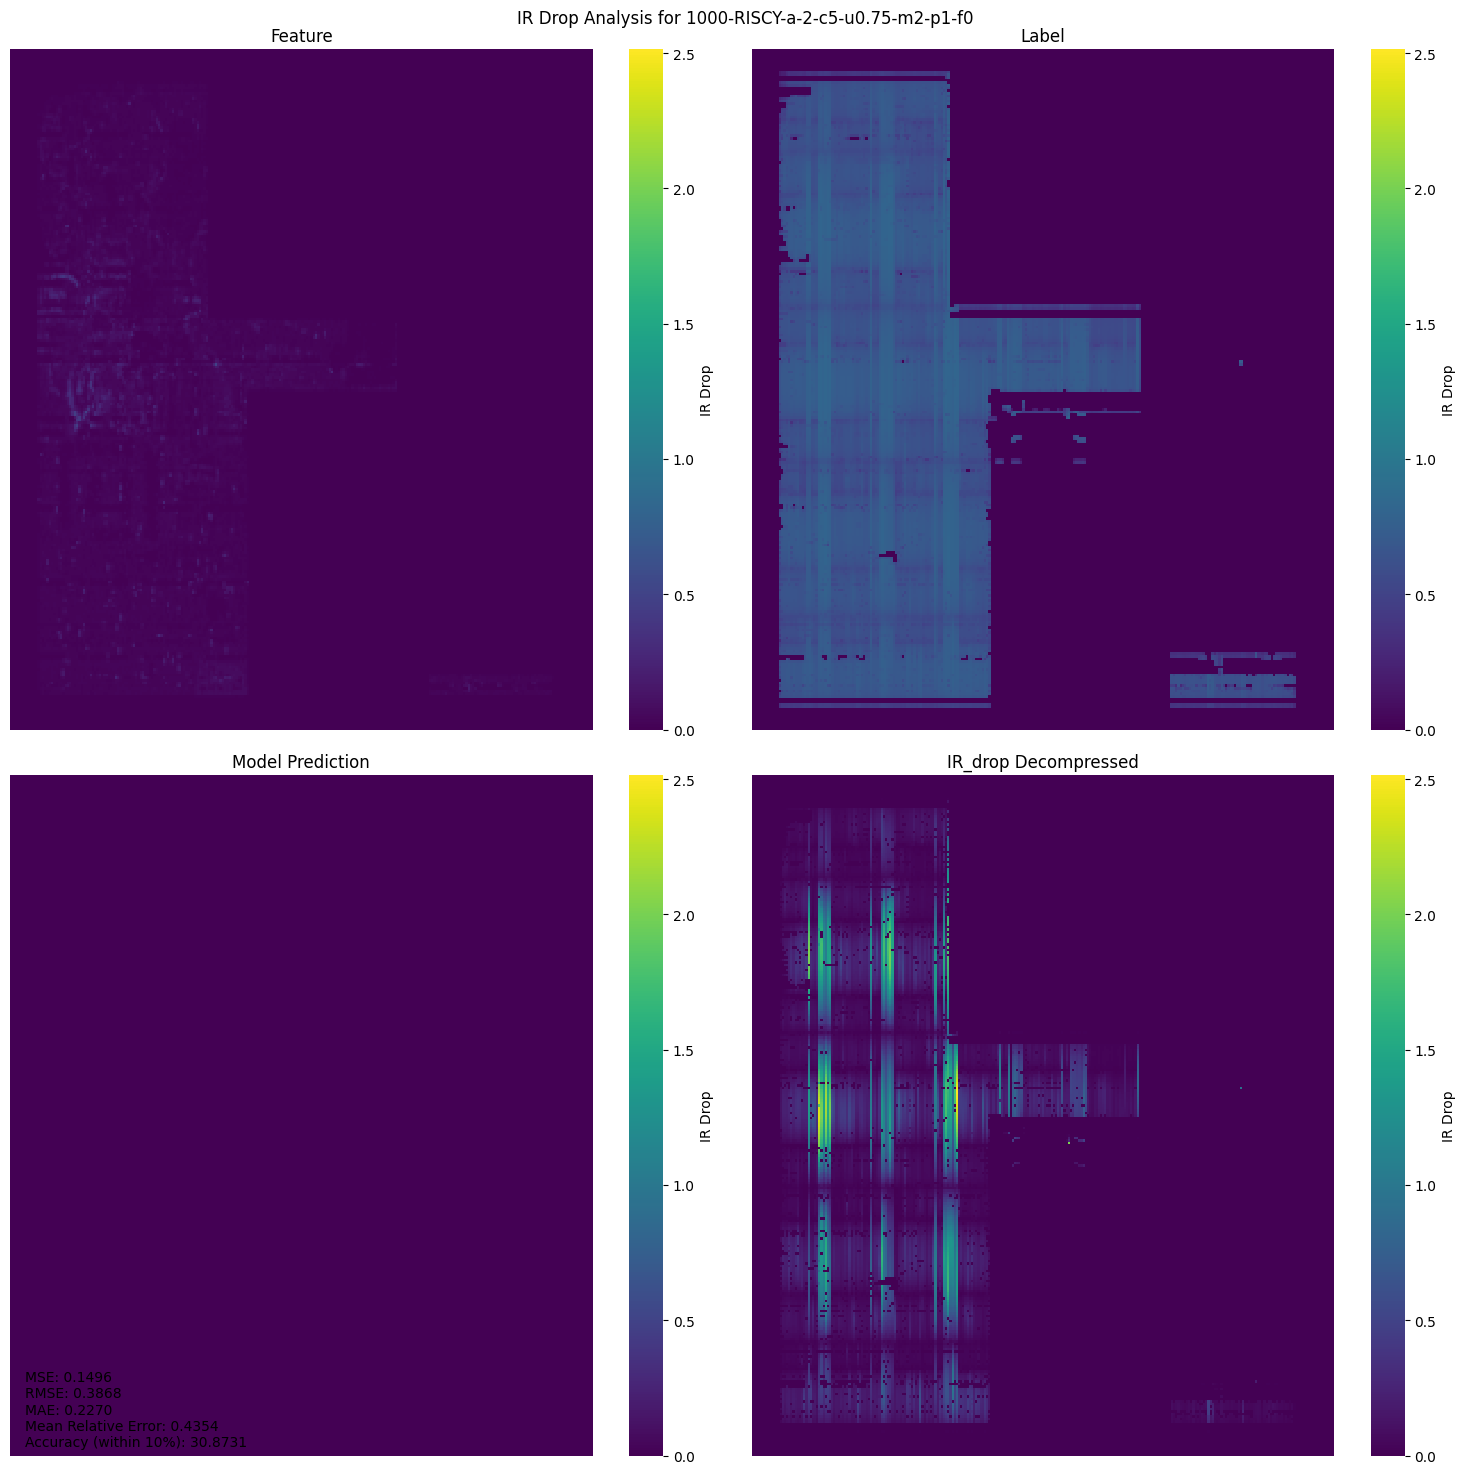

<Figure size 1500x1500 with 0 Axes>

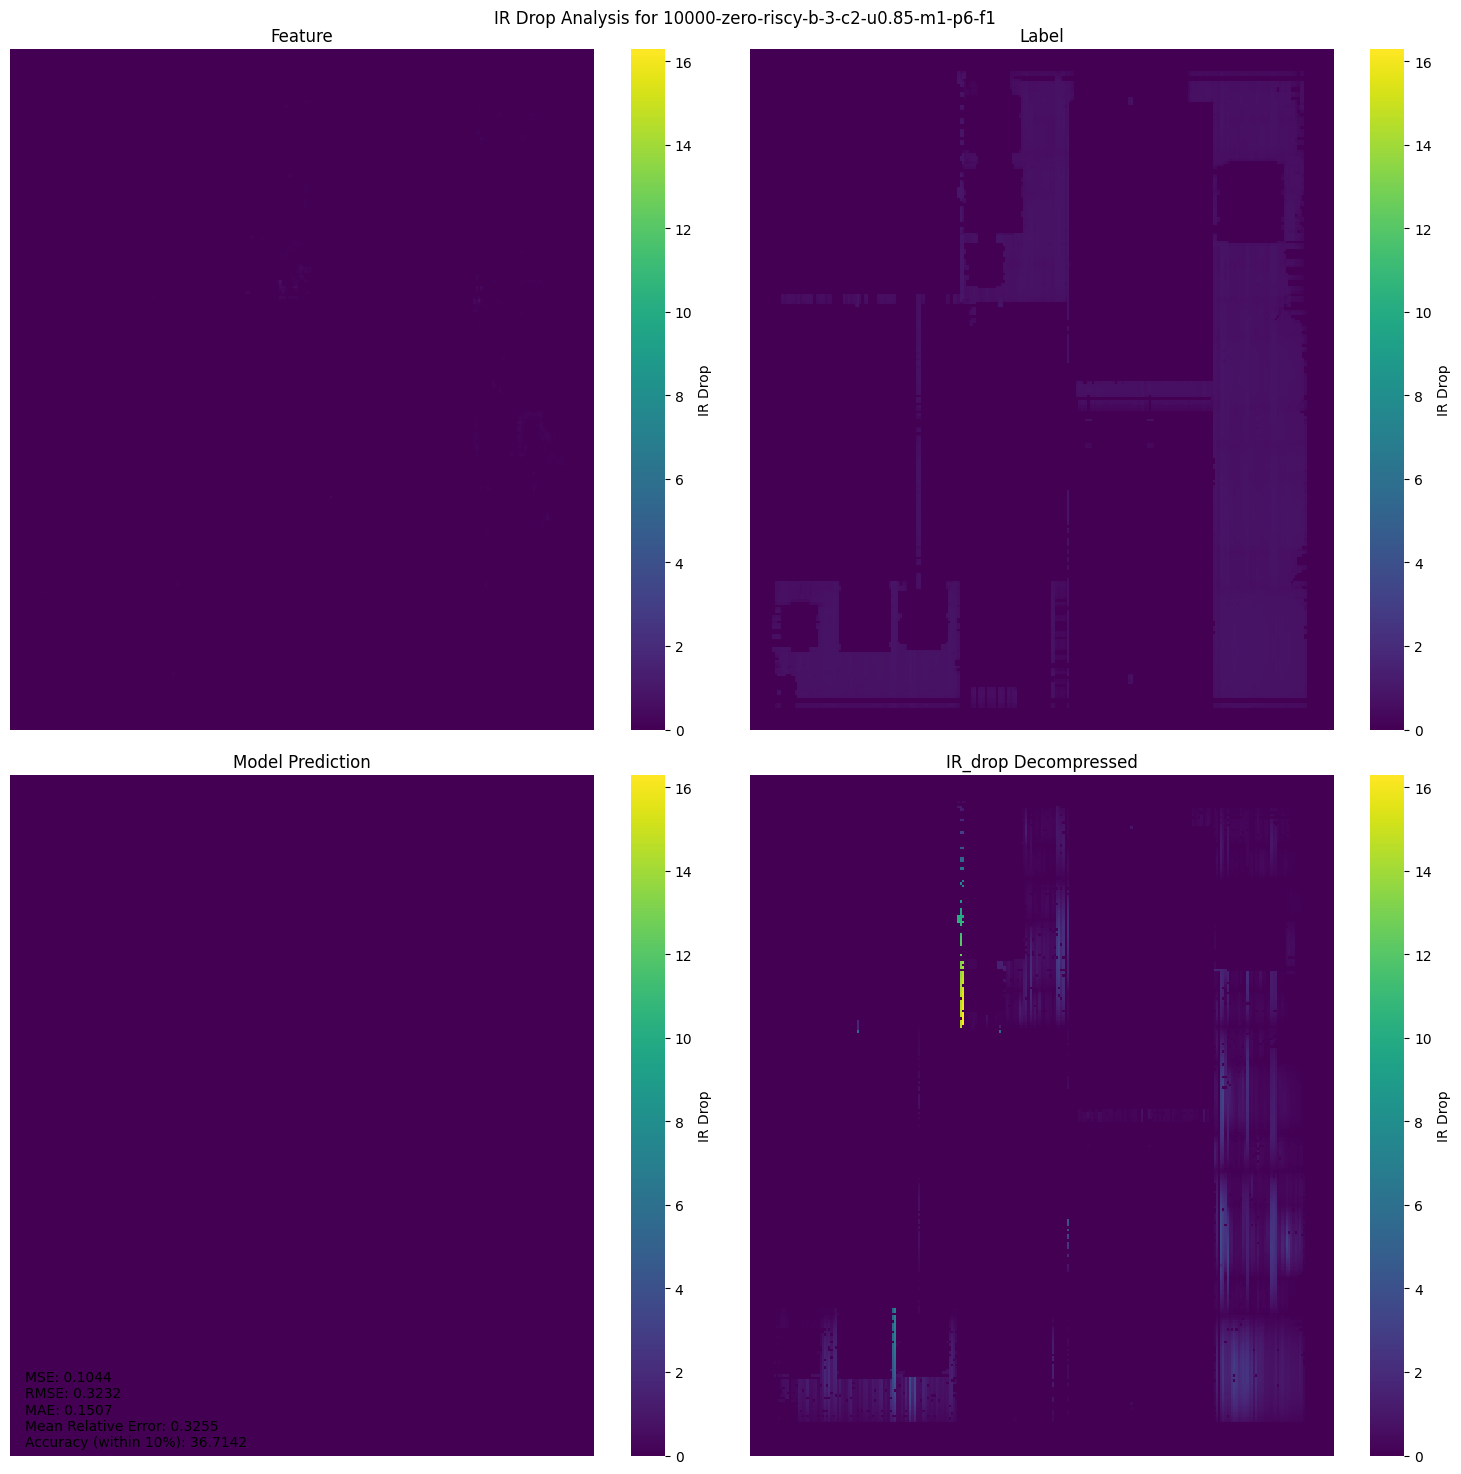


Average Metrics Across All Files:
MSE: 0.1690
RMSE: 0.4080
MAE: 0.2425
Mean Relative Error: 0.4328
Accuracy (within 10%): 32.8214


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from models.mavi import MAVI
from collections import OrderedDict
import os

def load_and_preprocess_data(filename, is_feature=True):
    """Load and preprocess IR drop data."""
    if is_feature:
        path = os.path.join('./CircuitNet-N28/training_set/IR_drop/feature', filename + '.npy')
    else:
        path = os.path.join('./CircuitNet-N28/training_set/IR_drop/label', filename + '.npy')
    
    data = np.load(path)
    
    if is_feature:
        data = torch.tensor(data, dtype=torch.float32)
        data = data.unsqueeze(0).unsqueeze(0)
    else:
        data = torch.tensor(data, dtype=torch.float32)
        if data.shape[-1] == 1:
            data = data.squeeze(-1)
    
    return data

def load_decompressed_data(filename):
    """Load decompressed IR drop data."""
    path = os.path.join('./CircuitNet-N28/IR_drop_features_decompressed/IR_drop', filename)
    data = np.load(path)
    if data.shape[-1] == 1:
        data = data.squeeze(-1)
    return torch.tensor(data, dtype=torch.float32)

def calculate_metrics(prediction, target):
    """Calculate metrics between prediction and target."""
    if prediction.shape != target.shape:
        prediction = prediction.squeeze()
        target = target.squeeze()
        
        if prediction.shape != target.shape:
            prediction = F.interpolate(prediction.unsqueeze(0).unsqueeze(0), 
                                    size=target.shape,
                                    mode='bilinear', 
                                    align_corners=True).squeeze()
    
    mse = F.mse_loss(prediction, target).item()
    rmse = np.sqrt(mse)
    mae = F.l1_loss(prediction, target).item()
    rel_error = torch.abs(prediction - target) / (target + 1e-8)
    mean_rel_error = rel_error.mean().item()
    accuracy = (rel_error <= 0.1).float().mean().item() * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Mean Relative Error': mean_rel_error,
        'Accuracy (within 10%)': accuracy
    }

def visualize_comparison(feature, label, prediction, decompressed, filename, metrics):
    """Visualize and compare feature, label, prediction and decompressed data."""
    plt.figure(figsize=(15, 15))
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Process feature (take mean across time dimension if 3D)
    if feature.dim() > 2:
        feature = feature.mean(-1)
    if feature.dim() > 2:
        feature = feature.squeeze()
    
    # Process prediction (ensure 2D)
    if prediction.dim() > 2:
        prediction = prediction.squeeze()
    
    # Ensure label and decompressed are 2D
    label = label.squeeze()
    decompressed = decompressed.squeeze()
    
    # Get global min and max for consistent scaling
    all_data = [feature.numpy(), label.numpy(), prediction.numpy(), decompressed.numpy()]
    vmin = min(data.min() for data in all_data)
    vmax = max(data.max() for data in all_data)
    
    # Plot data
    sns.heatmap(feature.numpy(), ax=axes[0, 0], cmap='viridis',
                vmin=vmin, vmax=vmax, cbar_kws={'label': 'IR Drop'})
    axes[0, 0].set_title('Feature')  # Removed "(Mean)"
    axes[0, 0].axis('off')
    
    sns.heatmap(label.numpy(), ax=axes[0, 1], cmap='viridis',
                vmin=vmin, vmax=vmax, cbar_kws={'label': 'IR Drop'})
    axes[0, 1].set_title('Label')
    axes[0, 1].axis('off')
    
    sns.heatmap(prediction.numpy(), ax=axes[1, 0], cmap='viridis',
                vmin=vmin, vmax=vmax, cbar_kws={'label': 'IR Drop'})
    axes[1, 0].set_title('Model Prediction')
    axes[1, 0].axis('off')
    
    sns.heatmap(decompressed.numpy(), ax=axes[1, 1], cmap='viridis',
                vmin=vmin, vmax=vmax, cbar_kws={'label': 'IR Drop'})
    axes[1, 1].set_title('IR_drop Decompressed')  # Changed from "Decompressed Data"
    axes[1, 1].axis('off')
    
    # Add metrics text
    plt.figtext(0.02, 0.02, '\n'.join(f'{k}: {v:.4f}' for k, v in metrics.items()),
                fontsize=10, va='bottom')
    
    plt.suptitle(f'IR Drop Analysis for {filename}')
    plt.tight_layout()
    plt.show()

def evaluate_with_visualization():
    # Get files
    feature_dir = './CircuitNet-N28/training_set/IR_drop/feature'
    filenames = sorted(os.listdir(feature_dir))[:5]  # Only process first 5 files
    filenames = [f.replace('.npy', '') for f in filenames]
    
    # Initialize model
    model = MAVI(in_channels=1, out_channels=4)
    checkpoint = torch.load('./checkpoints/model_iters_12000.pth', map_location='cpu')
    new_dict = OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        new_dict[k] = v
    model.load_state_dict(new_dict)
    model.eval()
    
    # Initialize aggregated metrics
    total_metrics = {
        'MSE': 0,
        'RMSE': 0,
        'MAE': 0,
        'Mean Relative Error': 0,
        'Accuracy (within 10%)': 0
    }
    valid_files = 0
    
    # Process each file
    for filename in filenames:
        try:
            feature = load_and_preprocess_data(filename, is_feature=True)
            label = load_and_preprocess_data(filename, is_feature=False)
            decompressed = load_decompressed_data(filename)
            
            with torch.no_grad():
                prediction = model(feature)
            
            metrics = calculate_metrics(prediction, label)
            
            # Accumulate metrics
            for metric_name, metric_value in metrics.items():
                total_metrics[metric_name] += metric_value
            valid_files += 1
            
            # Show visualization for last file only
            # if filename == filenames[-1]:
            visualize_comparison(feature, label, prediction, decompressed, filename, metrics)
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue
    
    # Print average metrics
    print("\nAverage Metrics Across All Files:")
    for metric_name, value in total_metrics.items():
        avg_value = value / valid_files
        print(f"{metric_name}: {avg_value:.4f}")

# For Jupyter notebook
%matplotlib inline

# Run the evaluation
evaluate_with_visualization()